# ITU YZV302(3)E Deep Learning Course Fall 2024

# HW3

# Q2: Part(a) Denoising-Autoencoder (35 pts)

In this question, you will explore and learn about autoencoders. Below, you are provided with a convolution-based autoencoder designed for the MNIST dataset. Running the code will train the autoencoder and then plot the loss curve against iterations.

The code will also show two pairs of input and target images, followed by a visualization of the hidden embedding space. The current experiment uses a hidden layer size of 2 for easier visualization, but this may be prevent learning complex problems. The embedding sizes can be increased to improve the quality of reconstructions but at the expense of visualizing the entire space. However, it is possible to plot dimensions individually to observe the a distributions. Learning compressed patterns will be easier using larger hidden embedding sizes.

In this this question you will convert the autoencoder into a Denoising Autoencoder. Here, you will create some controlled corruption in the input images, while the targets remain the original images. For example, you could delete a rectangular window from the image and ask the autoencoder to reconstruct the original. Alternatively, you could add Gaussian noise and ask the autoencoder to remove the noise.

The auto-encoder does not need to work perfectly. Play with the network, hyper-parameters as you wish, to create something which seems to work.

To get full points from this question
1. **[10 pts]** Implement the input image corruption code. Explain your corruption method. What factors influenced your choice?
2. **[5 pts]** Change the training loop to work as a denoising autoencoder.
3. **[5 pts]** Tune your architecture, training, corruption, and parameters briefly. Comment on what did you change and how it affected the results.
4. **[5 pts]** Comment on the results, plot at least TWO input-output pairs of of each digit (0-9). Describe your findings.
5. **[10 pts]** The current experiment runs only on the training set. It is possible that your autoencoder memorizes specific data points and corruptions, leading to poor generalization on unseen data. Does your network memorize or generalize denoising? Write down your answer in your analysis section and perform additional experiments to support your claims.

Note: You must implement the noise/corruption yourself.

For an example of what noisy/corrupted images look like, take a look at the 'noisy.png' image.

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# plot the latent (hidden) space
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [11]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
						train = True,
						download = True,
						transform = tensor_transform)

test_dataset = datasets.MNIST(root="./data",
                               train=False,
                               download=True,
                               transform=tensor_transform)
# DataLoader is used to load the dataset
# for training

batch_size = 32

loader = torch.utils.data.DataLoader(dataset = dataset,
									batch_size = batch_size,
									shuffle = True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
									batch_size = batch_size,
									shuffle = False, pin_memory=True)


# Write your data corruption/noising function here. Call it from appropriate position in training.


<span style="color:red;">Answer:</span> I chose salt-and-pepper noise because it is a type of impulsive noise that frequently occurs in digital images. This noise randomly replaces pixel values with extreme values, such as 1 (salt) or 0 (pepper), simulating sudden disturbances.

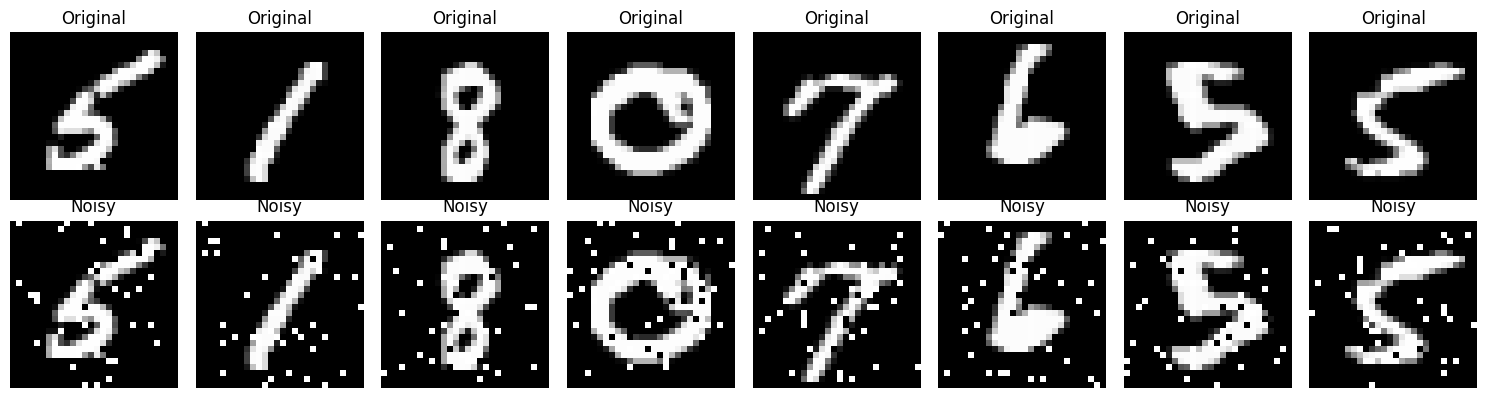

In [3]:
import matplotlib.pyplot as plt

def add_salt_and_pepper_noise(images, salt_prob=0.02, pepper_prob=0.02):
    noisy_images = images.clone()
    total_pixels = images[0].numel()  
    
    # Add salt 
    num_salt = int(total_pixels * salt_prob)
    for img in noisy_images:
        salt_coords = torch.randint(0, total_pixels, (num_salt,))
        img.view(-1)[salt_coords] = 1.0  

    # Add pepper 
    num_pepper = int(total_pixels * pepper_prob)
    for img in noisy_images:
        pepper_coords = torch.randint(0, total_pixels, (num_pepper,))
        img.view(-1)[pepper_coords] = 0.0  

    return noisy_images

def visualize_salt_and_pepper(original, noisy, n=8):
    fig, axes = plt.subplots(nrows=2, ncols=n, figsize=(15, 4))
    for i in range(n):
        # Original images
        axes[0, i].imshow(original[i].squeeze().numpy(), cmap="gray")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")
        
        # Noisy images
        axes[1, i].imshow(noisy[i].squeeze().numpy(), cmap="gray")
        axes[1, i].set_title("Noisy")
        axes[1, i].axis("off")
    
    plt.tight_layout()
    plt.show()

images, labels = next(iter(loader))

noisy_images = add_salt_and_pepper_noise(images, salt_prob=0.05, pepper_prob=0.05)

visualize_salt_and_pepper(images, noisy_images, n=8)


In [4]:
# auto encoder definition

# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        act = nn.LeakyReLU(0.01)
        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                act,
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                act,
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                act,
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, 32)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(32, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                act,
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                act,
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),
                act,
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(2, 2), padding=0),  # kernel size (2,2) to replace trim.
                #Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid() # perhaps you can remove this and use linear or tanh instead and scale the output back.
                )

    def forward(self, x):
        h = self.encoder(x)
        x = self.decoder(h)
        return x,h

In [15]:
# Model Initialization
model = AutoEncoder()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()

# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
							lr = 5e-4,
							weight_decay = 1e-5)


In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Parameter count: ", count_parameters(model))

Parameter count:  388993


In [17]:
epochs = 20
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in loader:
        images = images.to(DEVICE)
        
        noisy_images = add_salt_and_pepper_noise(images, salt_prob=0.05, pepper_prob=0.05)

        reconstructed, _ = model(noisy_images)

        loss = loss_function(reconstructed, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")


Epoch [1/20], Loss: 0.0197
Epoch [2/20], Loss: 0.0065
Epoch [3/20], Loss: 0.0056
Epoch [4/20], Loss: 0.0053
Epoch [5/20], Loss: 0.0051
Epoch [6/20], Loss: 0.0049
Epoch [7/20], Loss: 0.0048
Epoch [8/20], Loss: 0.0047
Epoch [9/20], Loss: 0.0046
Epoch [10/20], Loss: 0.0045
Epoch [11/20], Loss: 0.0045
Epoch [12/20], Loss: 0.0044
Epoch [13/20], Loss: 0.0044
Epoch [14/20], Loss: 0.0043
Epoch [15/20], Loss: 0.0043
Epoch [16/20], Loss: 0.0042
Epoch [17/20], Loss: 0.0042
Epoch [18/20], Loss: 0.0042
Epoch [19/20], Loss: 0.0042
Epoch [20/20], Loss: 0.0041


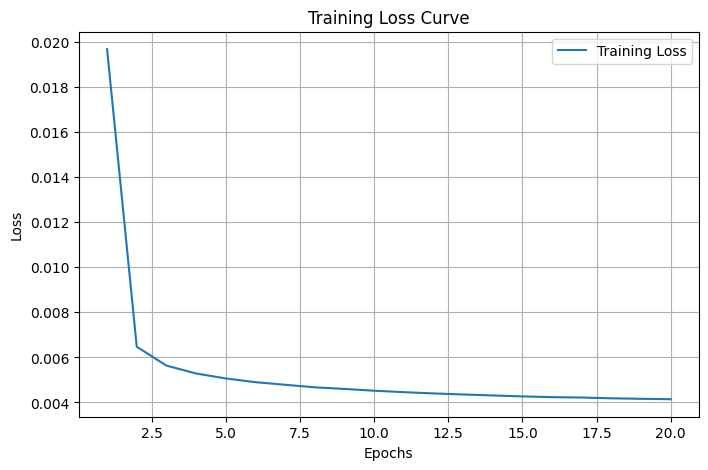

In [18]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.show()


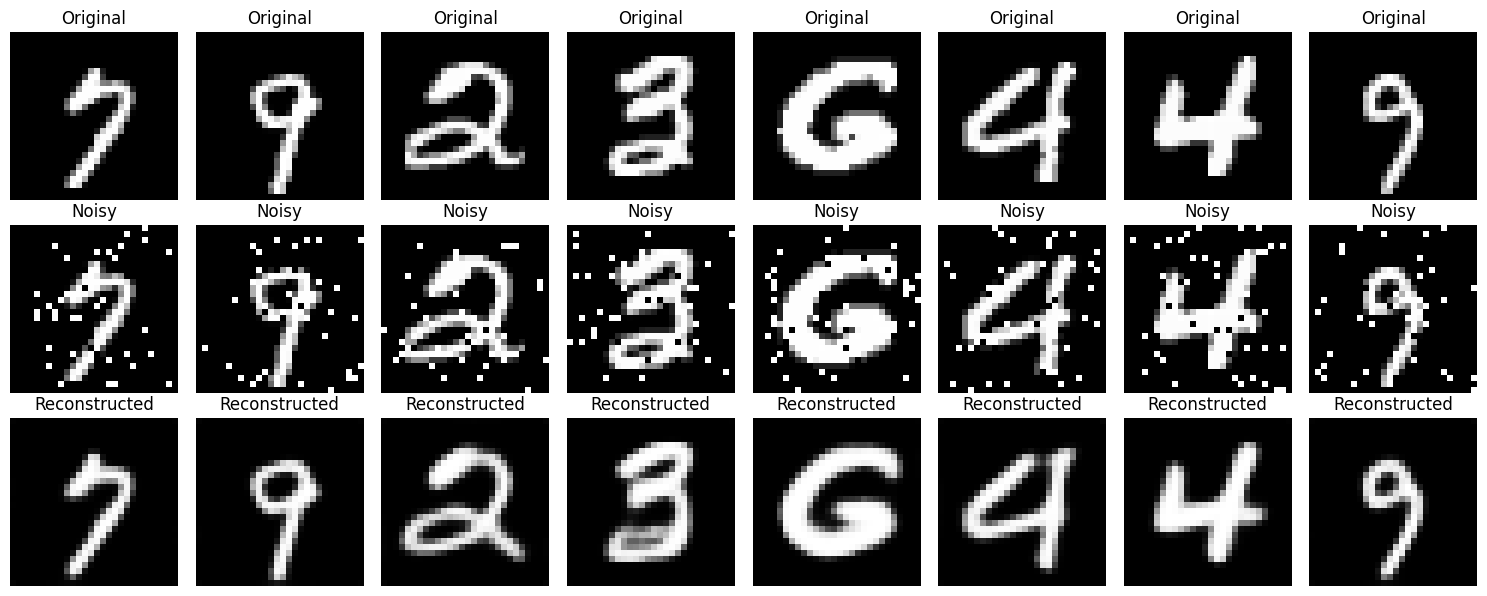

In [19]:
def visualize_reconstructions(original, noisy, reconstructed, n=8):
    fig, axes = plt.subplots(nrows=3, ncols=n, figsize=(15, 6))
    for i in range(n):
        axes[0, i].imshow(original[i].squeeze().cpu().numpy(), cmap="gray")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")
        
        axes[1, i].imshow(noisy[i].squeeze().cpu().numpy(), cmap="gray")
        axes[1, i].set_title("Noisy")
        axes[1, i].axis("off")
        
        axes[2, i].imshow(reconstructed[i].squeeze().detach().cpu().numpy(), cmap="gray")
        axes[2, i].set_title("Reconstructed")
        axes[2, i].axis("off")
    
    plt.tight_layout()
    plt.show()

images, _ = next(iter(loader))
images = images.to(DEVICE)
noisy_images = add_salt_and_pepper_noise(images, salt_prob=0.05, pepper_prob=0.05)

model.eval()
with torch.no_grad():
    reconstructed, _ = model(noisy_images)

visualize_reconstructions(images, noisy_images, reconstructed)


In [ ]:
# plot the latent space if 2D
import numpy as np
def plot_latent_space_with_labels(num_classes, data_loader, model, device):
    d = {i:[] for i in range(num_classes)}

    model.eval()
    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.to(device)

            embedding = model.encoder(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()

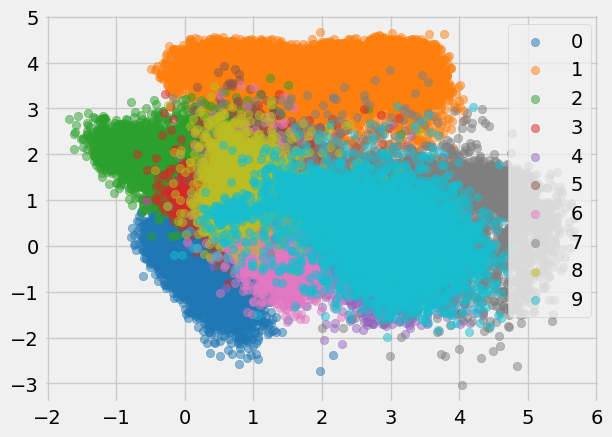

In [ ]:
# call the above function to produce the graph below.

plt.legend()
plt.show()

# Add your analysis below

<span style="color:red;">Answer:</span>

1. I successfully implemented salt-and-pepper noise to simulate impulsive disturbances in images.
2. I incorporated the noise addition into the training loop, calculating the loss between the original and noisy images. This helped the model learn to reconstruct clean images effectively.
3. To enhance reconstruction performance, I increased the latent space dimension of the autoencoder, enabling it to capture more features from the data. I also slightly increased the learning rate and epoch size. The higher learning rate improved convergence speed, but increasing the epoch size had minimal impact on performance and, beyond a certain point, risked overfitting.
4. I tested my model on the validation set of the MNIST dataset and observed that it performed remarkably well, demonstrating strong denoising capabilities.
5. The results show that my model has learned to generalize denoising effectively, making it robust for unseen noisy data.

Test Loss: 0.0007


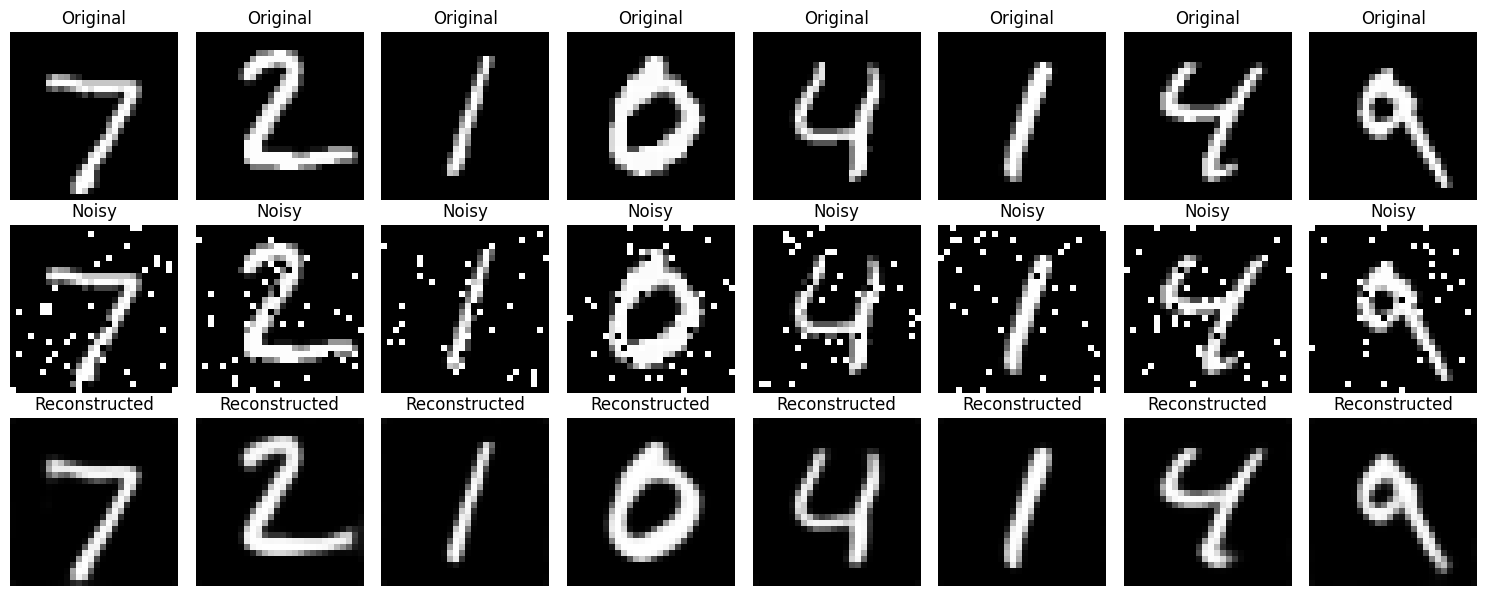

In [20]:
val_loss = 0.0
model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(DEVICE)
        noisy_images = add_salt_and_pepper_noise(images, salt_prob=0.05, pepper_prob=0.05)
        
        reconstructed, _ = model(noisy_images)
        
        loss = loss_function(reconstructed, images)
        val_loss += loss.item()

val_loss /= len(loader)
print(f"Test Loss: {val_loss:.4f}")

images, _ = next(iter(test_loader))
images = images.to(DEVICE)
noisy_images = add_salt_and_pepper_noise(images, salt_prob=0.05, pepper_prob=0.05)

model.eval()
with torch.no_grad():
    reconstructed, _ = model(noisy_images)

visualize_reconstructions(images, noisy_images, reconstructed)


# Q2-Part(b) - Variational AutoEncoders VAE   [25 pts]

In this section you are required to implement Variational Autoencoder. The general structure for VAE is given below. You can use it as a template.

Variational Autoencoder is a type of autoencoder that can be used as a generative model. It has a reparametrization trick in the bottleneck to allow gradient-based optimization.

There are couple of studies you can examine before implementing the model.

Auto-Encoding Variational Bayes: 
https://arxiv.org/abs/1312.6114

Understanding Variational Autoencoders (VAEs): https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

### Load the SVHN data

In [21]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

batch_size = 64 # You can change this value depending on your GPU memory

train_data = datasets.SVHN(root = "data", split = 'train', transform = transforms.ToTensor(), download = True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True) 

test_data = datasets.SVHN(root = "data", split = 'test', transform = transforms.ToTensor(), download = True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True) 

100%|██████████| 182040794/182040794 [00:09<00:00, 18515358.10it/s]


100%|██████████| 64275384/64275384 [00:05<00:00, 11350110.85it/s]


### Implement the VAE Architecture of your Design [12 pts]

Use Conv2d, ConvTranspose2d, Linear, and Activation Layers to design a Variational Autoencoder Architecture

In [37]:
class VAE(torch.nn.Module):
    """
    Implement Variational Autoencoder for SVHN dataset
    """
    def __init__(self, latent_dim=256):
        """
        Implement architecture
        """
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 16, 16)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: (256, 4, 4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Flatten()  # Output: (256 * 4 * 4)
        )
        
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: (128, 8, 8)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 16, 16)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # Output: (3, 32, 32)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        """
        Implement forward-pass [2 pts]
        """
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z)
        x = x.view(-1, 256, 4, 4)
        recon_x = self.decoder(x)
        
        return recon_x, mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        Implement reparameterization trick [6 pts]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        out = mu + eps * std
        
        return out

    def loss_function(self, recon_x, x, mu, logvar):
        """
        Implement loss function [7 pts]
        """
        recon_loss = F.mse_loss(recon_x, x, reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = recon_loss + kld_loss
        
        return loss

### Initialization of the Optimizer: You can change the Parameters according to your needs

In [45]:
# Model Initialization
model = VAE()
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(DEVICE)

# Using an Adam Optimizer with lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(),
							lr = 5e-5,
							weight_decay = 1e-5)


### Implement training loop [1 pt]

In [47]:
epochs = 40
losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, _ in train_loader:
        images = images.to(DEVICE)

        reconstructed, mu, logvar = model(images)

        loss = model.loss_function(reconstructed, images, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(loader)
    losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}")

for images, _ in test_loader:
    images = images.to(DEVICE)

    reconstructed, mu, logvar = model(images)

    loss = model.loss_function(reconstructed, images, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

avg_loss = epoch_loss / len(loader)
print(f"Test Loss: {avg_loss:.4f}")

Epoch [1/40], Train Loss: 1417.9878
Epoch [2/40], Train Loss: 1413.8759
Epoch [3/40], Train Loss: 1410.7667
Epoch [4/40], Train Loss: 1409.0365
Epoch [5/40], Train Loss: 1407.0177
Epoch [6/40], Train Loss: 1405.9369
Epoch [7/40], Train Loss: 1403.1248
Epoch [8/40], Train Loss: 1401.3403
Epoch [9/40], Train Loss: 1400.5539
Epoch [10/40], Train Loss: 1398.4419
Epoch [11/40], Train Loss: 1396.6463
Epoch [12/40], Train Loss: 1393.9001
Epoch [13/40], Train Loss: 1394.4086
Epoch [14/40], Train Loss: 1392.4149
Epoch [15/40], Train Loss: 1390.8392
Epoch [16/40], Train Loss: 1388.6877
Epoch [17/40], Train Loss: 1388.2854
Epoch [18/40], Train Loss: 1386.2481
Epoch [19/40], Train Loss: 1386.3111
Epoch [20/40], Train Loss: 1384.5692
Epoch [21/40], Train Loss: 1382.5382
Epoch [22/40], Train Loss: 1381.0602
Epoch [23/40], Train Loss: 1379.3446
Epoch [24/40], Train Loss: 1380.0450
Epoch [25/40], Train Loss: 1378.5245
Epoch [26/40], Train Loss: 1378.0208
Epoch [27/40], Train Loss: 1377.9227
Epoch [28/

### Report the training loss curves for VAE. [1 pt]

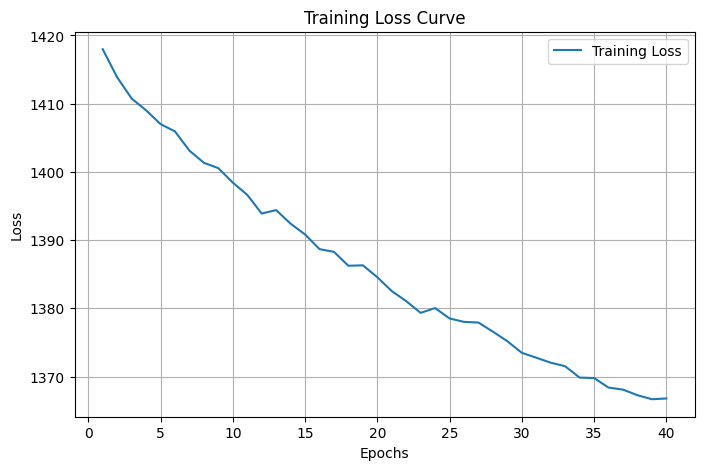

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1 ), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.show()


### Show test results (generated images) for VAE. Also briefly discuss the results. [4 pts]

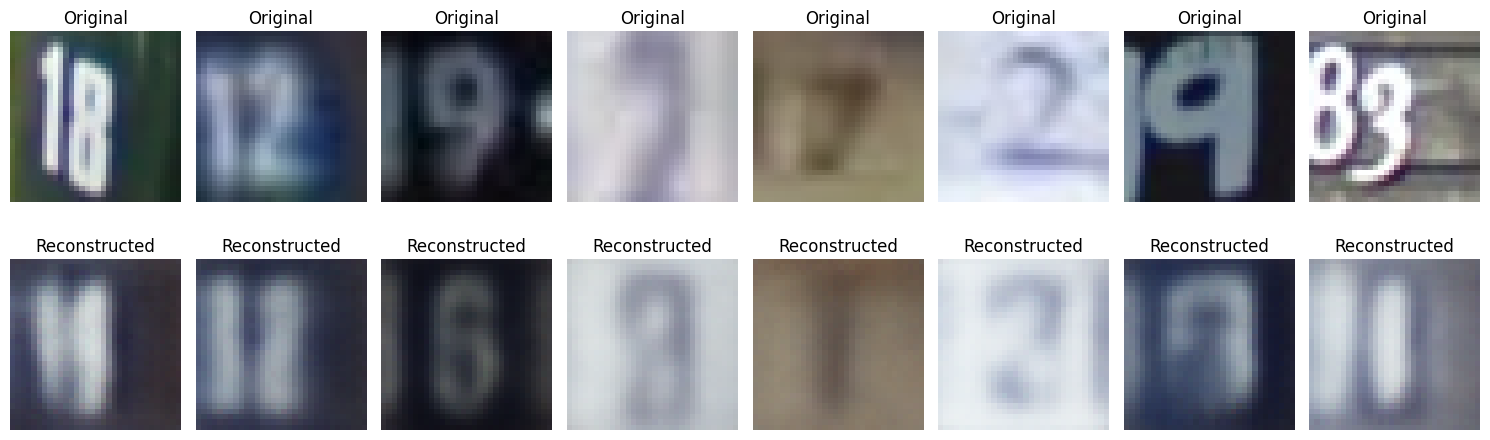

In [49]:
import matplotlib.pyplot as plt
import torch

def show_test_results(model, test_loader, device, num_images=8):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            images, _ = batch
            images = images.to(device)
            
            recon_images, _, _ = model(images)
            break  
    
    images = images.cpu()
    recon_images = recon_images.cpu()
    
    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[0, i].imshow(images[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")
        
        axes[1, i].imshow(recon_images[i].permute(1, 2, 0).clamp(0, 1))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstructed")
    
    plt.tight_layout()
    plt.show()

show_test_results(model, test_loader, DEVICE)


### Randomly generate a sample then traverse in its latent space dimensions (add small numbers to only one dimension) see how it affects generated images. [7 pts]

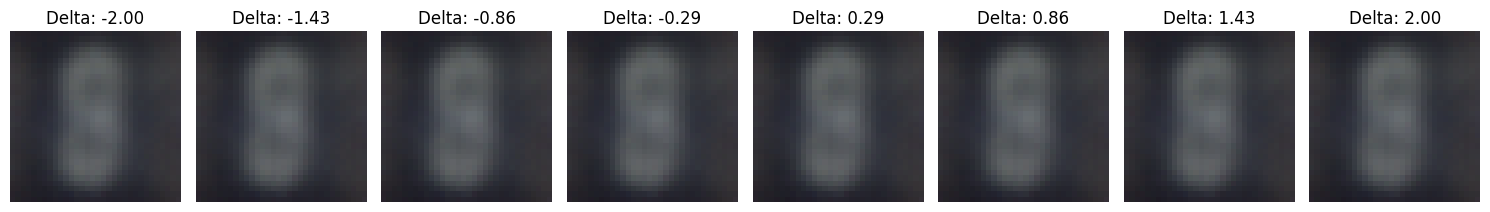

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def latent_space_traversal(model, device, latent_dim=256, num_variations=8, traversal_range=2.0):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, latent_dim).to(device)
        
        variations = np.linspace(-traversal_range, traversal_range, num_variations)
        generated_images = []
        
        for delta in variations:
            z_variation = z.clone()
            z_variation[0, 0] += delta  
            
            decoded_image = model.decoder(model.fc_decode(z_variation).view(-1, 256, 4, 4))
            generated_images.append(decoded_image.cpu().squeeze(0).permute(1, 2, 0).clamp(0, 1))
    
    fig, axes = plt.subplots(1, num_variations, figsize=(15, 5))
    for i, img in enumerate(generated_images):
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Delta: {variations[i]:.2f}")
    
    plt.tight_layout()
    plt.show()

latent_space_traversal(model, DEVICE)


#### After you have completed the training, save your model and share a google drive link for the model